In [ ]:
! pip install torch tensorflow transformers

In [2]:
import tensorflow as tf
from transformers import TFAutoModel, AutoTokenizer
import torch
import matplotlib.pyplot as plt

2024-05-04 01:18:30.800174: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-04 01:18:31.460733: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/tranhuy/Desktop/Project/cantho-public-services/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

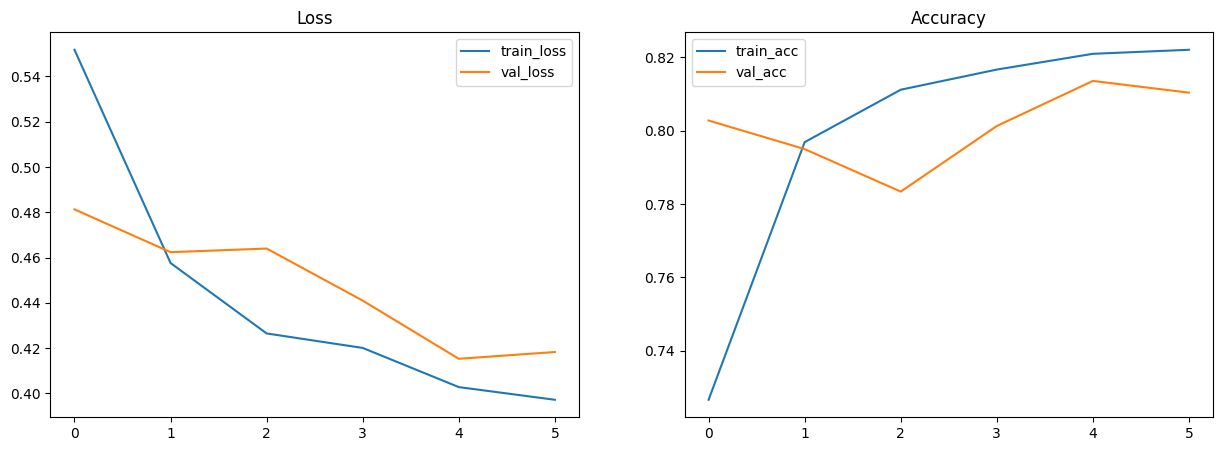

In [4]:
train_loss = []
train_acc = []
val_loss = []
val_acc = []

with open("../filter-model/model2/score", "r") as f:
    for line in f:
        scores = line.split(",")
        scores = [float(score.strip()) for score in scores]
        train_loss.append(scores[0])
        train_acc.append(scores[1])
        val_loss.append(scores[2])
        val_acc.append(scores[3])

axes, fig = plt.subplots(1, 2, figsize=(15, 5))

fig[0].plot(train_loss, label="train_loss")
fig[0].plot(val_loss, label="val_loss")
fig[0].legend()
fig[0].set_title("Loss")

fig[1].plot(train_acc, label="train_acc")
fig[1].plot(val_acc, label="val_acc")
fig[1].legend()
fig[1].set_title("Accuracy")

plt.show()

In [5]:
with tf.device('/cpu:0'):
    model = TFAutoModel.from_pretrained("vinai/phobert-base-v2", from_pt=True)
    tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base-v2")

2024-05-04 01:18:43.033616: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
/home/tranhuy/Desktop/Project/cantho-public-services/venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
2024-05-04 01:18:43.037311: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355

In [6]:
class BERTForClassification(tf.keras.Model):

    def __init__(self, bert_model, num_classes):
        super().__init__()
        self.bert = bert_model
        self.bert.trainable = False
        self.fc1 = tf.keras.layers.Dense(256, activation='relu')
        self.fc2 = tf.keras.layers.Dense(30, activation='relu')
        self.fc3 = tf.keras.layers.Dense(num_classes, activation='softmax')

    def call(self, inputs):
        x = self.bert(inputs)[1]
        x = self.fc1(x)
        x = self.fc2(x)
        return self.fc3(x)

In [8]:
with tf.device('/cpu:0'):
    classifier = BERTForClassification(model, num_classes=2)
    classifier.load_weights('../filter-model/model2/checkpoint/')

2024-05-04 01:19:13.666258: W tensorflow/core/util/tensor_slice_reader.cc:98] Could not open ../filter-model/model2/checkpoint/: FAILED_PRECONDITION: ../filter-model/model2/checkpoint; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?
2024-05-04 01:19:13.713149: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 196611072 exceeds 10% of free system memory.


In [21]:
text = "context: Thủ tục hành chính tên thủ tục đăng ký khai sinh đối với trường hợp bị mất hoặc hư hỏng với mã 1.002150.000.00.00.H13 được thực hiện theo trình tự thực hiện như sau \nquestion: cấp lại giấy chứng sinh có trình tự thực hiện như thế nào?"
tokenized_text = tokenizer([text, text], return_tensors="tf", padding=True, truncation=True, max_length=512)

In [22]:
with tf.device('/cpu:0'):
    output = classifier.call(tokenized_text)
output

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[0.3991537 , 0.60084635],
       [0.39915335, 0.6008466 ]], dtype=float32)>

In [20]:
model.trainable = False
model.summary()

Model: "tf_roberta_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 roberta (TFRobertaMainLaye  multiple                  134998272 
 r)                                                              
                                                                 
Total params: 134998272 (514.98 MB)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 134998272 (514.98 MB)
_________________________________________________________________
